## Library

In [ ]:
#Loading libraries
!pip install textstat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')

from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

#for displaying 500 results in pandas dataframe
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


import re
import gensim
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
from collections import defaultdict,Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import string
nltk.download('stopwords')


stop=set(stopwords.words('english'))
plt.style.use('seaborn')


from plotly import tools
import plotly.offline as py
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import textstat
from textblob import TextBlob 
from tqdm import tqdm
from statistics import *
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

     |████████████████████████████████| 102kB 6.1MB/s 
     |████████████████████████████████| 1.9MB 22.4MB/s 
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##Path

In [ ]:
images_dir = '/content/gdrive/MyDrive/Statistical computing Final project/images'
files_dir = '/content/gdrive/MyDrive/Statistical computing Final project/files'

## Data

In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/gdrive') # 此處需要登入google帳號
# 獲取授權碼之後輸入即可連動雲端硬碟
train = pd.read_csv("/content/gdrive/MyDrive/Statistical computing Final project/data/Corona_NLP_train.csv",encoding='latin1')
test = pd.read_csv("/content/gdrive/MyDrive/Statistical computing Final project/data/Corona_NLP_test.csv",encoding='latin1')
df=pd.concat([train,test])
df['OriginalTweet']=df['OriginalTweet'].astype(str)
df['Sentiment']=df['Sentiment'].astype(str)

train['OriginalTweet']=train['OriginalTweet'].astype(str)
train['Sentiment']=train['Sentiment'].astype(str)
test['OriginalTweet']=test['OriginalTweet'].astype(str)
test['Sentiment']=test['Sentiment'].astype(str)


Mounted at /content/gdrive


In [ ]:
# Drop duplicates
train.drop_duplicates()
print(" Shape of dataframe after dropping duplicates: ", df.shape)
null= df.isnull().sum().sort_values(ascending=False)
total =df.shape[0]
percent_missing= (df.isnull().sum()/total).sort_values(ascending=False)

missing_data= pd.concat([null, percent_missing], axis=1, keys=['Total missing', 'Percent missing'])

missing_data.reset_index(inplace=True)
missing_data= missing_data.rename(columns= { "index": " column name"})
 
print ("Null Values in each column:\n", missing_data)

 Shape of dataframe after dropping duplicates:  (44955, 6)
Null Values in each column:
      column name  Total missing  Percent missing
0       Location           9424         0.209632
1      Sentiment              0         0.000000
2  OriginalTweet              0         0.000000
3        TweetAt              0         0.000000
4     ScreenName              0         0.000000
5       UserName              0         0.000000


In [ ]:
print('Total tweets in this data: {}'.format(df.shape[0]))
print('Total Unique Users in this data: {}'.format(df['UserName'].nunique()))

Total tweets in this data: 44955
Total Unique Users in this data: 44955


In [ ]:
print(df.Sentiment.unique())
print(df.Sentiment.value_counts())

['Neutral' 'Positive' 'Extremely Negative' 'Negative' 'Extremely Positive']
Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
Name: Sentiment, dtype: int64


In [ ]:
df['text'] = df.OriginalTweet
df["text"] = df["text"].astype(str)

train['text'] = train.OriginalTweet
train["text"] = train["text"].astype(str)

test['text'] = test.OriginalTweet
test["text"] = test["text"].astype(str)

# Data has 5 classes, let's convert them to 3

def classes_def(x):
    if x ==  "Extremely Positive":
        return "positive"
    elif x == "Extremely Negative":
        return "negative"
    elif x == "Negative":
        return "negative"
    elif x ==  "Positive":
        return "positive"
    else:
        return "neutral"
    
df['sentiment']=df['Sentiment'].apply(lambda x:classes_def(x))
train['sentiment']=train['Sentiment'].apply(lambda x:classes_def(x))
test['sentiment']=test['Sentiment'].apply(lambda x:classes_def(x))
target=df['sentiment']

df.sentiment.value_counts(normalize= True)

positive    0.435814
negative    0.378846
neutral     0.185341
Name: sentiment, dtype: float64

## EDA

In [ ]:
class_df = df.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
class_df.style.background_gradient(cmap='summer')

,sentiment,text
2,positive,19592
0,negative,17031
1,neutral,8332


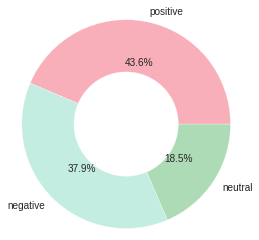

In [ ]:
percent_class=class_df.text
labels= class_df.sentiment
colors = ['#f8afba','#c3ede1','#addbb6']
my_pie,_,_ = plt.pie(percent_class,radius = 1.2,labels=labels,colors=colors,autopct="%.1f%%")
plt.setp(my_pie, width=0.6, edgecolor='white') 
plt.savefig(f"{images_dir}/covid_pie.png")
plt.show()

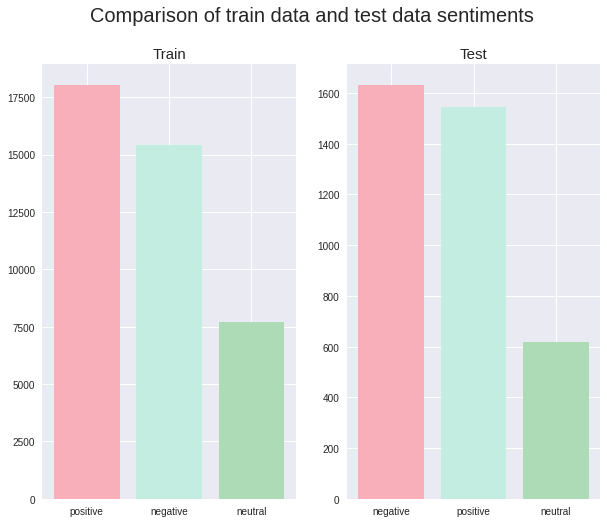

In [ ]:
class_train = train.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
class_test = test.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
percent_train=class_train.text
labels_train= class_train.sentiment
percent_test=class_test.text
labels_test= class_test.sentiment
plt.figure(figsize=(10,8))
plt.suptitle("Comparison of train data and test data sentiments", fontsize=20)
plt.subplot(121)
plt.bar(labels_train,percent_train, color=['#f8afba','#c3ede1','#addbb6'])
plt.gca().set_title("Train", fontsize=15)
plt.subplot(122)
plt.bar(labels_test,percent_test, color=['#f8afba','#c3ede1','#addbb6'])
plt.gca().set_title("Test", fontsize=15)
plt.savefig(f"{images_dir}/comparison.png")
plt.show()

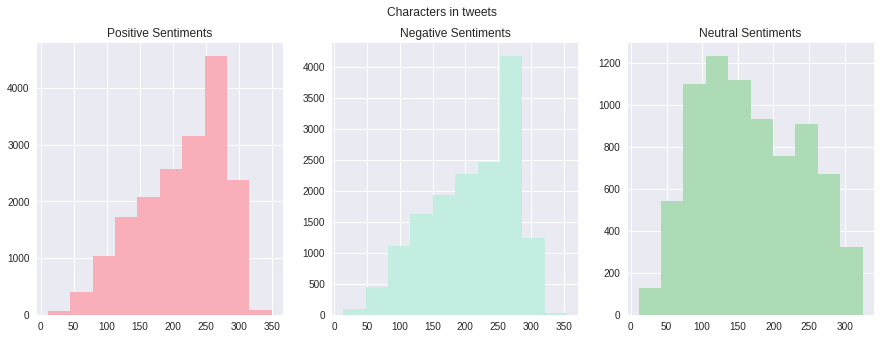

In [ ]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

tweet_len=train[train['sentiment']=="positive"]['text'].str.len()
ax1.hist(tweet_len,color='#f8afba')
ax1.set_title('Positive Sentiments')

tweet_len=train[train['sentiment']=="negative"]['text'].str.len()
ax2.hist(tweet_len,color='#c3ede1')
ax2.set_title('Negative Sentiments')

tweet_len=train[train['sentiment']=="neutral"]['text'].str.len()
ax3.hist(tweet_len,color='#addbb6')
ax3.set_title('Neutral Sentiments')

fig.suptitle('Characters in tweets')
plt.savefig(f"{images_dir}/Characters in tweets.png")
plt.show()

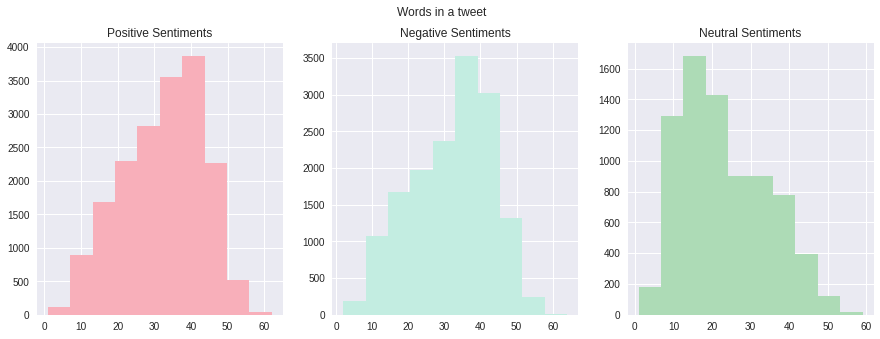

In [ ]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

tweet_len=train[train['sentiment']=="positive"]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='#f8afba')
ax1.set_title('Positive Sentiments')


tweet_len=train[train['sentiment']=="negative"]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='#c3ede1')
ax2.set_title('Negative Sentiments')

tweet_len=train[train['sentiment']=="neutral"]['text'].str.split().map(lambda x: len(x))
ax3.hist(tweet_len,color='#addbb6')
ax3.set_title('Neutral Sentiments')

fig.suptitle('Words in a tweet')
plt.savefig(f"{images_dir}/words in tweets.png")
plt.show()


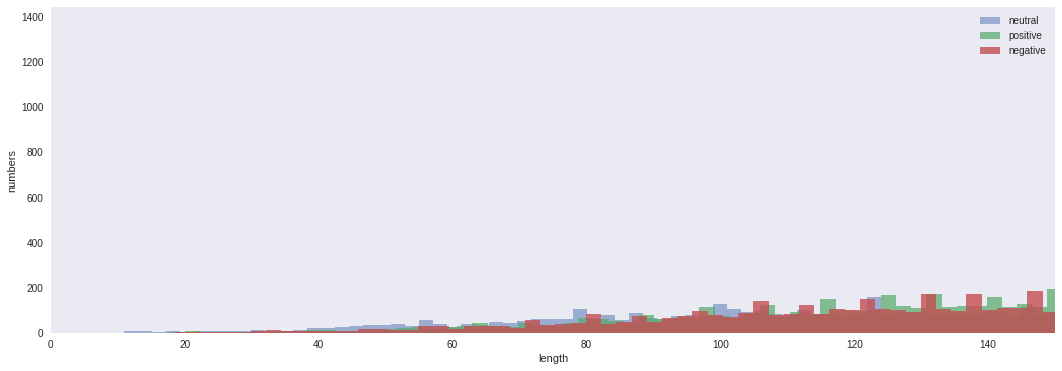

In [ ]:
def length(text):    
    '''a function which returns the length of text'''
    return len(text)
df['length'] = df['text'].apply(length)

plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 150
plt.hist(df[df['sentiment'] == "neutral"]['length'], alpha = 0.5, bins=bins, label='neutral')
plt.hist(df[df['sentiment'] == "positive"]['length'], alpha = 0.7, bins=bins, label='positive')
plt.hist(df[df['sentiment'] == "negative"]['length'], alpha = 0.8, bins=bins, label='negative')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,150)
plt.grid()
plt.savefig(f"{images_dir}/text length.png")
plt.show()

Text(0.5, 0.98, 'Average word length in each tweet')

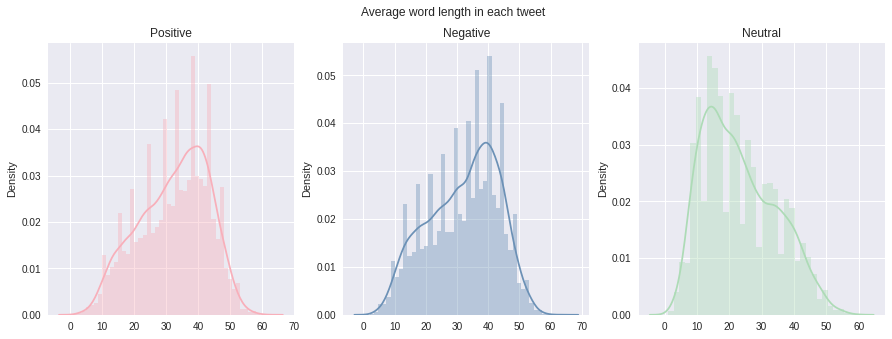

In [ ]:
fig,(ax1,ax2, ax3)=plt.subplots(1,3,figsize=(15,5))
def count_word(x):
  return(len(x))
word=train[train['sentiment']=="positive"]['text'].str.split()
b = list(map(count_word,word))
sns.distplot(b,ax=ax1,color=colors[0])
ax1.set_title('Positive')


word=train[train['sentiment']=="negative"]['text'].str.split()
b = list(map(count_word,word))
sns.distplot(b,ax=ax2,color="#6c91b6")
ax2.set_title('Negative')


word=train[train['sentiment']=="neutral"]['text'].str.split()
b = list(map(count_word,word))
sns.distplot(b,ax=ax3,color=colors[2])
ax3.set_title('Neutral')
plt.savefig(f"{images_dir}/word length.png")
fig.suptitle('Average word length in each tweet')

### Common Stopwords in the tweets

In [ ]:
np.array(stop)#nltk stopwords

array({'should', 'down', 'with', "haven't", 'in', 'why', 'hers', 'than', 'aren', 'our', 'no', 'itself', 'out', 'how', "weren't", 'y', "didn't", 'on', 'shouldn', 'each', "she's", 'which', 'yourselves', "isn't", 'were', 'have', 'does', 'all', 'so', 'not', 'to', "needn't", 'about', "you'd", 'both', 'won', "won't", "that'll", 'did', 'o', 'now', 'of', "shan't", 'what', 'up', 'at', "mustn't", 'from', 'while', 'yours', 'their', 'against', 'him', 'mustn', 't', 'that', 'do', 'doesn', 'doing', 'whom', 'most', 'an', 'has', "wouldn't", 'those', 'needn', "hadn't", "couldn't", 'off', "don't", 'don', 's', 'over', 'couldn', 'are', "you've", 'ourselves', 'again', "you're", 'until', 'i', "shouldn't", 'after', 'between', 'before', 're', 've', "it's", 'themselves', 'same', 'she', 'this', 'isn', 'my', 'his', 'these', 'its', 'we', 'into', 'shan', 'mightn', 'through', 'you', 'too', 'hasn', 'wasn', 'the', 'because', 'myself', 'during', "hasn't", 'where', 'but', 'and', 'for', 'above', 'wouldn', "mightn't", 'a'

In [ ]:
comment_words = '' 
stopwords = set(STOPWORDS) 
# from wordcloud import STOPWORDS

for val in stop: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "

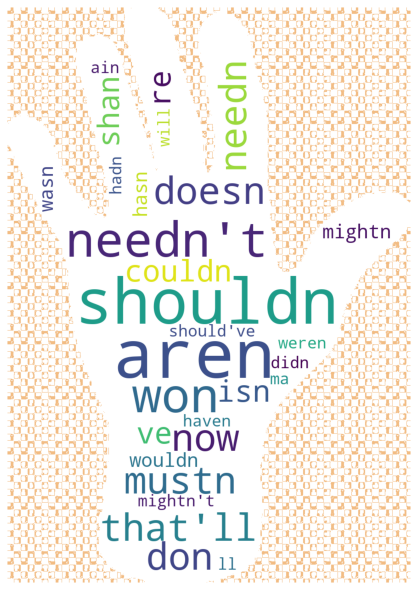

In [ ]:
hand_mask = np.array(Image.open("/content/gdrive/MyDrive/Statistical computing Final project/files/hand-mask.png"))#图像 == Numpy 数组 np.array
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                stopwords = stopwords, 
                contour_width=1, 
                contour_color='#f2bc83',
                mask=hand_mask,
                min_font_size = 10).generate(comment_words) #取comment_word中不在stopword裡的字
plt.figure(figsize = (8, 8), facecolor = "white") 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.savefig(f"{images_dir}/common_word word cloud.png")
plt.show() 

In [ ]:
def create_corpus(target):
    corpus=[]
    for x in train[train['sentiment']==target ]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

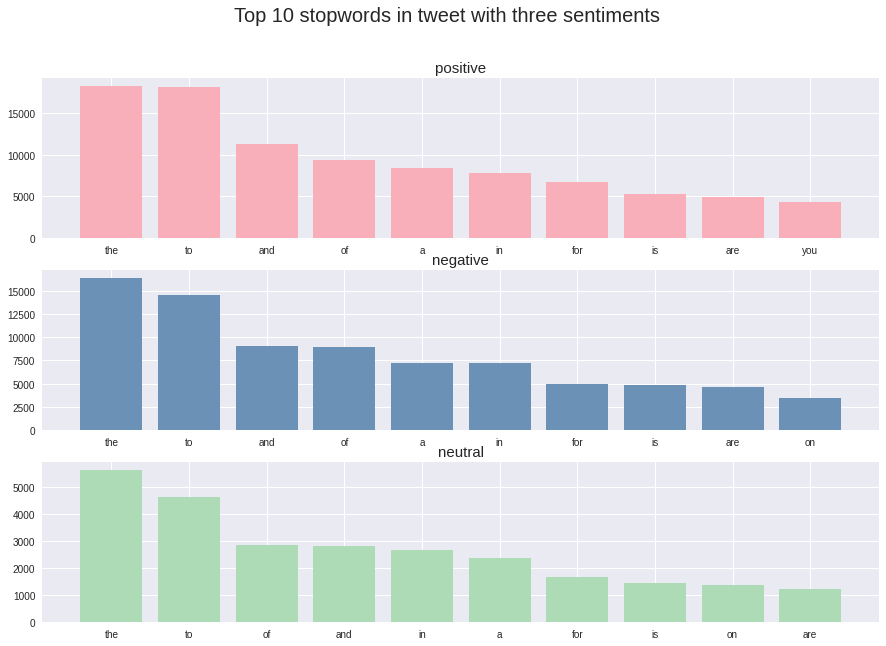

In [ ]:
corpus=create_corpus("positive")
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1         
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] #按照dict的第二格來排序
x,y=zip(*top)
plt.figure(figsize=(15,10))
plt.suptitle("Top 10 stopwords in tweet with three sentiments", fontsize=20)
plt.subplot(311)
plt.gca().set_title("positive", fontsize=15)
plt.bar(x,y, color=colors[0])

corpus=create_corpus("negative")
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1          
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] #按照dict的第二格來排序
x,y=zip(*top)
plt.subplot(312)
plt.bar(x,y, color="#6c91b6")
plt.gca().set_title("negative", fontsize=15)

corpus=create_corpus("neutral")
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1           
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] #按照dict的第二格來排序
x,y=zip(*top)
plt.subplot(313)
plt.bar(x,y, color=colors[2])
plt.gca().set_title("neutral", fontsize=15)
plt.savefig(f"{images_dir}/top10 stopword.png")
plt.show() 

### Punctuation

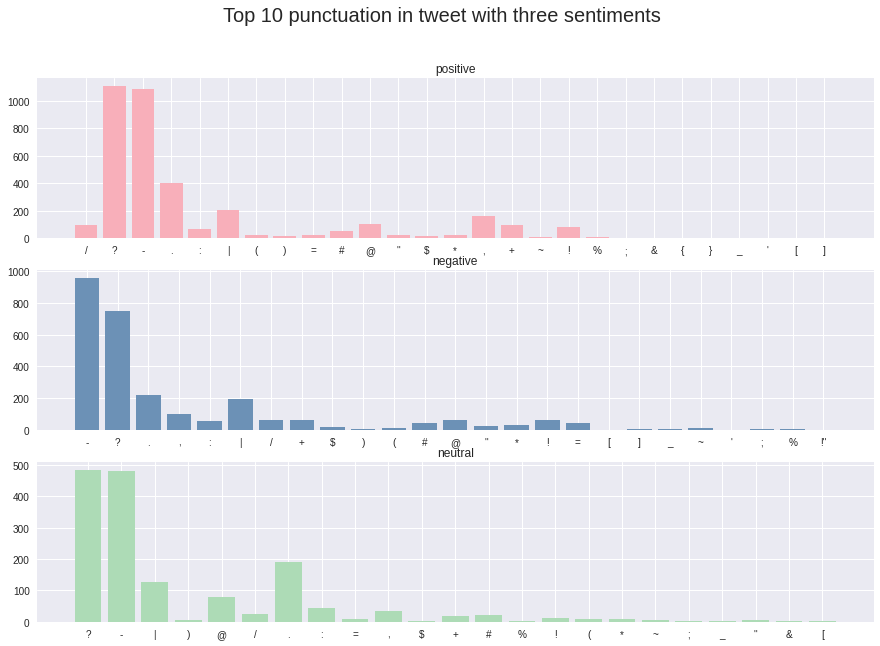

In [ ]:
plt.figure(figsize=(15,10))
corpus=create_corpus("positive")
dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1      
x,y=zip(*dic.items())
plt.suptitle("Top 10 punctuation in tweet with three sentiments", fontsize=20)
plt.subplot(311)
plt.gca().set_title("positive", fontsize=12)
plt.bar(x,y, color=colors[0])


corpus=create_corpus("negative")
dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1      
x,y=zip(*dic.items())
plt.subplot(312)
plt.bar(x,y, color="#6c91b6")
plt.gca().set_title("negative", fontsize=12)

corpus=create_corpus("neutral")
dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1      
x,y=zip(*dic.items())
plt.subplot(313)
plt.bar(x,y, color=colors[2])
plt.gca().set_title("neutral", fontsize=12)
plt.savefig(f"{images_dir}/top10 stopword.png")
plt.show() 

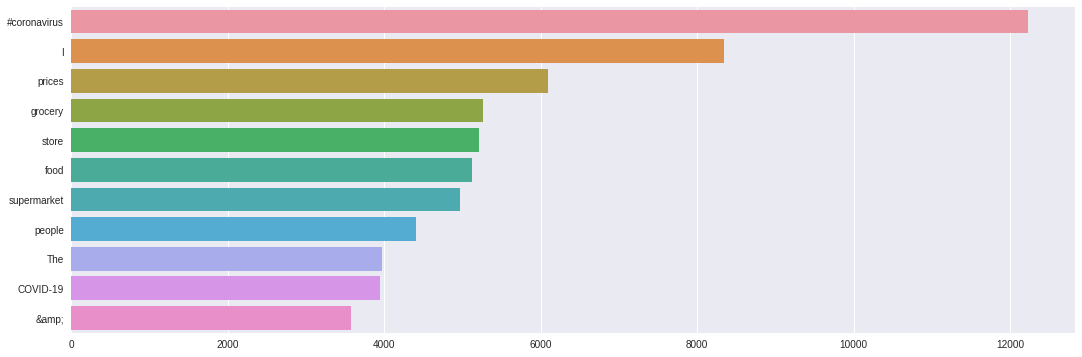

In [ ]:
corpus1=create_corpus("neutral")
corpus2=create_corpus("negative")
corpus3=create_corpus("positive")
corpus=corpus1+corpus2+corpus3
counter=Counter(corpus)
most=counter.most_common()
dic={}
for word,count in most[:40]:
    if (word not in stop) :
        dic[word]=count
        # y.append(count)
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)
# list(dic.keys())
sns.barplot(x=list(dic.values()),y=list(dic.keys()))
plt.savefig(f"{images_dir}/top word.png")
plt.show()

### Hashtags

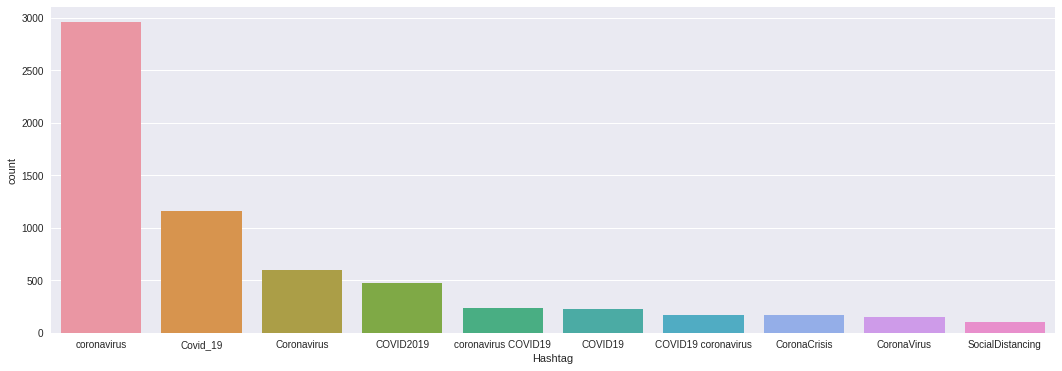

In [ ]:
def find_hash(text):
    line=re.findall(r'(?<=#)\w+',text)
    return " ".join(line)
df['hash']=df['text'].apply(lambda x:find_hash(x))
temp=df['hash'].value_counts()[:][1:11] #取第一到第11個
temp= temp.to_frame().reset_index().rename(columns={'index':'Hashtag','hash':'count'})# to dataframe, rename(index -> Hashtag)
sns.barplot(x="Hashtag",y="count", data = temp)
plt.savefig(f"{images_dir}/top hashtag.png")
plt.show()

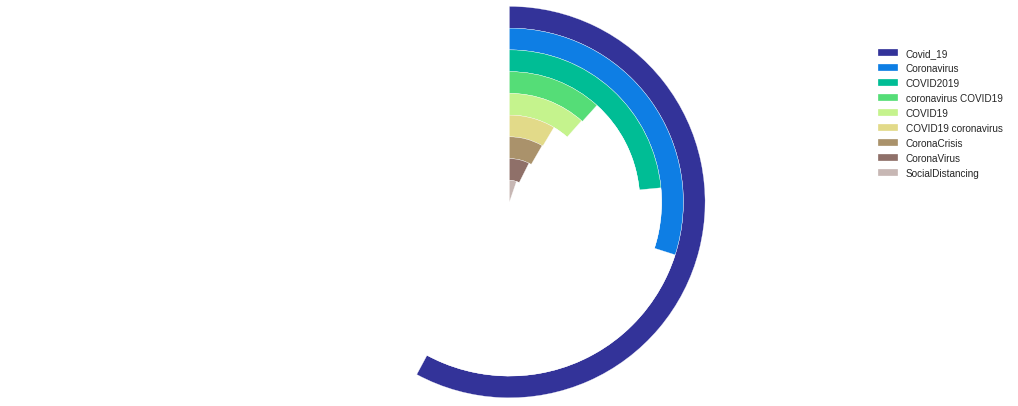

In [ ]:
from matplotlib import cm
from math import log10

labels = df['hash'].value_counts()[:][2:11].index.tolist()
data = df['hash'].value_counts()[:][2:11]

df['hash'].value_counts()[:][1:11].index.tolist()
#number of data points
n = len(data)
#find max value for full ring
k = 10 ** int(log10(max(data)))
m = k * (1 + max(data) // k)

#radius of donut chart
r = 1.5
#calculate width of each ring
w = r / n 

#create colors along a chosen colormap
colors = [cm.terrain(i / n) for i in range(n)]

#create figure, axis
fig, ax = plt.subplots()
ax.axis("equal")

#create rings of donut chart
for i in range(n):
    #hide labels in segments with textprops: alpha = 0 - transparent, alpha = 1 - visible
    innerring, _ = ax.pie([m - data[i], data[i]], radius = r - i * w, startangle = 90, labels = ["", labels[i]], labeldistance = 1 - 1 / (1.5 * (n - i)), textprops = {"alpha": 0}, colors = ["white", colors[i]])
    plt.setp(innerring, width = w, edgecolor = "white")

plt.legend()
plt.savefig(f"{images_dir}/top hashtag round.png")
plt.show()

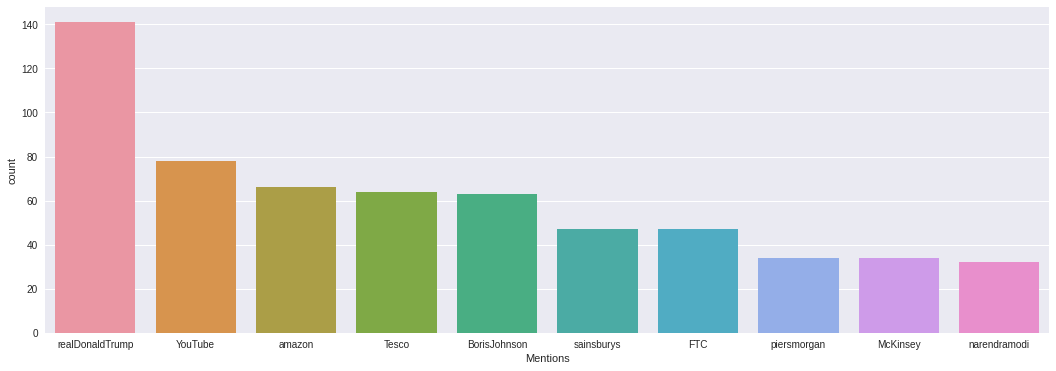

In [ ]:
def mentions(text):
    line=re.findall(r'(?<=@)\w+',text)
    return " ".join(line)
df['mentions']=df['text'].apply(lambda x:mentions(x))

temp=df['mentions'].value_counts()[:][1:11]
temp =temp.to_frame().reset_index().rename(columns={'index':'Mentions','mentions':'count'})

sns.barplot(x="Mentions",y="count", data = temp)
plt.savefig(f"{images_dir}/top mention.png")
plt.show()

In [ ]:
df.to_csv (r'/content/gdrive/MyDrive/Statistical computing Final project/files/df_new.csv', index = False, header=True)